## LOAD DATA

In [1]:
!pip install tensorflow_text

     |████████████████████████████████| 3.4MB 4.2MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import collections
import pathlib
import re
import string

import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras import utils
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

import tensorflow_datasets as tfds
import tensorflow_text as tf_text
import pandas as pd
import numpy as np

In [4]:
df = pd.read_csv("/content/drive/MyDrive/main_lines_verses.csv")

In [5]:
from sklearn.utils import shuffle
df = shuffle(df)

In [6]:
df.head()

,artist_name,line
10124,"Ad-Rock, Mike D, MCA",Remember the good old days with the rockabilly...
131308,Vinnie,Which meanin that you FAKE ASS NIGGAZ who conn...
189925,Method Man,"That's on e'rythang, put it on the kids and th..."
191617,"Method Man, Samples",Who y’all kiddin’? Tryin to act like my shoe f...
195589,Xzibit,Get it crackin' to the third degree


In [7]:
# df.replace("Jay-Z", "JAY-Z", inplace=True)
# df.replace("KRS-One", "KRS-ONE", inplace=True)
# df.replace("LL Cool J", "L.L. Cool J", inplace=True)
# df.replace("Royce da 5'9", "Royce Da 5'9", inplace=True)
df.replace("Notorious B.I.G.", "The Notorious B.I.G.", inplace=True)
df = df.groupby('artist_name').filter(lambda x : len(x)>1000)
df = df[df['line'].apply(lambda x: len(x.split(" ")) > 3)]

In [9]:
list = ['The Notorious B.I.G.', 'Ice Cube', 'Nas', '2Pac', 'Method Man', 'Eminem',
        'Ghostface Killah', 'Snoop Dogg', 'DMX', 'Dr. Dre', 'GZA', 'RZA']
df = df[df['artist_name'].isin(list)]

In [10]:
df['artist_name'].value_counts()

Eminem                  8377
Ice Cube                4381
Nas                     3821
2Pac                    3775
Method Man              3331
Ghostface Killah        3063
The Notorious B.I.G.    2695
Snoop Dogg              2626
DMX                     2562
Dr. Dre                 2235
GZA                     2033
RZA                     1762
Name: artist_name, dtype: int64

In [11]:
west_coast_list = ['Ice Cube', '2Pac', 'Eminem', 'Snoop Dogg', 'Dr. Dre']
df["coast"] = ["W" if el in west_coast_list else "E" for el in df["artist_name"]]
df.drop(['artist_name'], axis=1, inplace=True)
df.head()

,line,coast
189925,"That's on e'rythang, put it on the kids and th...",E
72920,Vision impaired when the silhouette emerged,E
348,Your city is the bomb if your city makin' pay,W
173972,Straight to the County with no motherfuckin' bail,W
34291,"You don't know, fuck it, find out the hard way",E


In [12]:
lyrics_features = df['line']
lyrics_labels = df.pop('coast')

In [13]:
lyrics_labels

189925    E
72920     E
348       W
173972    W
34291     E
         ..
1523      W
115223    E
126772    E
3380      W
79804     W
Name: coast, Length: 40661, dtype: object

In [14]:
set(lyrics_labels)

{'E', 'W'}

In [16]:
lyrics_labels = lyrics_labels.astype("category")

In [18]:
coast_ids = dict(enumerate(lyrics_labels.cat.categories))
coast_ids

{0: 'E', 1: 'W'}

In [19]:
lyrics_labels = lyrics_labels.cat.codes

In [20]:
lyrics_labels

189925    0
72920     0
348       1
173972    1
34291     0
         ..
1523      1
115223    0
126772    0
3380      1
79804     1
Length: 40661, dtype: int8

In [21]:
lyrics_ds = tf.data.Dataset.from_tensor_slices((lyrics_features, lyrics_labels))

In [22]:
BUFFER_SIZE = 38000
BATCH_SIZE = 64
VALIDATION_SIZE = 3000

In [24]:
all_labeled_data = lyrics_ds.shuffle(
    BUFFER_SIZE, reshuffle_each_iteration=False)

for text, label in all_labeled_data.take(10):
  print("Line: ", text.numpy())
  print("Coast:", label.numpy())

Line:  b"Life full of riches avoid snitches 'cause they shady, back in the days"
Coast: 1
Line:  b"'Cause it's only one percent"
Coast: 1
Line:  b'Look at all the bullshit I been through'
Coast: 0
Line:  b'Like round chuck, and still put hands on you'
Coast: 1
Line:  b"I'm not Mr. N'Sync, I'm not what your friends think"
Coast: 1
Line:  b"I'm not telling you to diss Mr. Ice Cube"
Coast: 1
Line:  b'I hope you get to read this letter, I just hope it reaches you in time'
Coast: 1
Line:  b'Sayin the best part of the day is my half'
Coast: 0
Line:  b'Many dreams is what I had, and plenty wishes'
Coast: 1
Line:  b'Big juicy legs and a nice pair of kegs'
Coast: 1


In [25]:
AUTOTUNE = tf.data.AUTOTUNE

def configure_dataset(dataset):
  return dataset.cache().prefetch(buffer_size=AUTOTUNE)

### RNN CLASSIFIER

In [26]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [27]:
VOCAB_SIZE = 8000

In [28]:
train_dataset = all_labeled_data.skip(VALIDATION_SIZE).shuffle(BUFFER_SIZE)
test_dataset = all_labeled_data.take(VALIDATION_SIZE)

In [29]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [30]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print('lebal: ', label.numpy()[:3])

texts:  [b'When me and my posse stepped in the house'
 b'With whiskers like a rat, compared to Beans you whack'
 b"He's up, we's up, East up"]
lebal:  [1 0 1]


In [31]:
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [32]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]


array(['', '[UNK]', 'the', 'i', 'a', 'to', 'and', 'you', 'my', 'in', 'it',
       'me', 'im', 'on', 'of', 'with', 'that', 'like', 'your', 'up'],
      dtype='<U15')

In [33]:
encoded_example = encoder(example)[:10].numpy()
encoded_example

array([[  34,   11,    6,    8, 2521, 1108,    9,    2,  211,    0,    0,
           0],
       [  15,    1,   17,    4, 2518, 3702,    5, 3747,    7, 3102,    0,
           0],
       [ 234,   19, 4999,   19, 1185,   19,    0,    0,    0,    0,    0,
           0],
       [  34,    2,    1,    6,    2,  825,  369, 4088,    5,  345,    0,
           0],
       [  10,   30, 4495, 7843,   21,    7,    5,    1,    2,  349, 6698,
           0],
       [ 244,    9,    4,  242,  420,  499,    1,   65,    2,  935,    0,
           0],
       [  76,  435,   46,  207,  159,    3,  260,    2,  292,    1,    0,
           0],
       [  22,   16,  193,  158, 1899,   45, 4692,    0,    0,    0,    0,
           0],
       [   3,  840,   73,    5,  526,    2,   70,   45,    2,    1,    0,
           0],
       [   3,  356,   33,  336,   27,  491,  365,  578,   63,  150,   10,
          50]])

In [34]:
for n in range(10):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'When me and my posse stepped in the house'
Round-trip:  when me and my posse stepped in the house   

Original:  b'With whiskers like a rat, compared to Beans you whack'
Round-trip:  with [UNK] like a rat compared to beans you whack  

Original:  b"He's up, we's up, East up"
Round-trip:  hes up wes up east up      

Original:  b'When The Neptunes and the Doggy Dogg fin to spit'
Round-trip:  when the [UNK] and the doggy dogg fin to spit  

Original:  b'It was prime urgent, for you to examine the rhyme merchant'
Round-trip:  it was prime urgent for you to [UNK] the rhyme merchant 

Original:  b'Walk in a straight line, ten paces, down the road'
Round-trip:  walk in a straight line ten [UNK] down the road  

Original:  b"These cats know what's good, I am the hood (Aii)"
Round-trip:  these cats know whats good i am the hood [UNK]  

Original:  b"But that didn't stop fate from happening"
Round-trip:  but that didnt stop fate from happening     

Original:  b'I learned not to tr

In [35]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])


In [38]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [40]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
589/589 [==============================] - 17s 29ms/step - loss: 0.6634 - accuracy: 0.5281 - val_loss: 0.6168 - val_accuracy: 0.6203
Epoch 2/10
589/589 [==============================] - 15s 25ms/step - loss: 0.5681 - accuracy: 0.6847 - val_loss: 0.5923 - val_accuracy: 0.6698
Epoch 3/10
589/589 [==============================] - 15s 25ms/step - loss: 0.5150 - accuracy: 0.7311 - val_loss: 0.6011 - val_accuracy: 0.6979
Epoch 4/10
589/589 [==============================] - 15s 25ms/step - loss: 0.4846 - accuracy: 0.7530 - val_loss: 0.6031 - val_accuracy: 0.6927
Epoch 5/10
589/589 [==============================] - 15s 25ms/step - loss: 0.4632 - accuracy: 0.7688 - val_loss: 0.6137 - val_accuracy: 0.6896
Epoch 6/10
589/589 [==============================] - 15s 25ms/step - loss: 0.4472 - accuracy: 0.7779 - val_loss: 0.6259 - val_accuracy: 0.6974
Epoch 7/10
589/589 [==============================] - 15s 25ms/step - loss: 0.4315 - accuracy: 0.7895 - val_loss: 0.6376 - val_accuracy:

In [41]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

47/47 [==============================] - 0s 9ms/step - loss: 0.6954 - accuracy: 0.6787
Test Loss: 0.6954459547996521
Test Accuracy: 0.6786666512489319


In [47]:
!pip install pyyaml h5py  # Required to save models in HDF5 format

!mkdir -p saved_model
model.save('saved_model/my_model') 

INFO:tensorflow:Assets written to: saved_model/my_model/assets


INFO:tensorflow:Assets written to: saved_model/my_model/assets


(0.0, 0.7105538621544838)

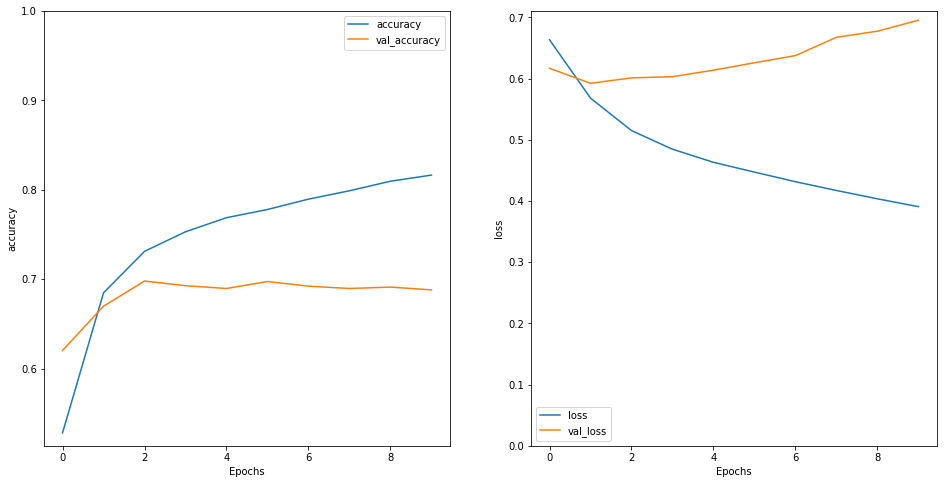

In [48]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [51]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])


In [52]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [53]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=10)

Epoch 1/10
589/589 [==============================] - 48s 46ms/step - loss: 0.6843 - accuracy: 0.4836 - val_loss: 0.6351 - val_accuracy: 0.6250
Epoch 2/10
589/589 [==============================] - 23s 38ms/step - loss: 0.5834 - accuracy: 0.6619 - val_loss: 0.6243 - val_accuracy: 0.6484
Epoch 3/10
589/589 [==============================] - 22s 38ms/step - loss: 0.5204 - accuracy: 0.7314 - val_loss: 0.6225 - val_accuracy: 0.6859
Epoch 4/10
589/589 [==============================] - 22s 38ms/step - loss: 0.4869 - accuracy: 0.7589 - val_loss: 0.6371 - val_accuracy: 0.6766
Epoch 5/10
589/589 [==============================] - 22s 38ms/step - loss: 0.4554 - accuracy: 0.7825 - val_loss: 0.6424 - val_accuracy: 0.6625
Epoch 6/10
589/589 [==============================] - 22s 38ms/step - loss: 0.4369 - accuracy: 0.7959 - val_loss: 0.6722 - val_accuracy: 0.6562
Epoch 7/10
589/589 [==============================] - 22s 38ms/step - loss: 0.4231 - accuracy: 0.8019 - val_loss: 0.6789 - val_accuracy:

In [54]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

47/47 [==============================] - 1s 14ms/step - loss: 0.7042 - accuracy: 0.6767
Test Loss: 0.7041543126106262
Test Accuracy: 0.6766666769981384


In [55]:
!mkdir -p saved_model
model.save('saved_model/rnn_coast_classifier_1_1') 

INFO:tensorflow:Assets written to: saved_model/rnn_coast_classifier_1_1/assets


INFO:tensorflow:Assets written to: saved_model/rnn_coast_classifier_1_1/assets


In [56]:
sample_text = ('Hilary Clinton tried to slap me and call me a pervert')
predictions = model.predict(np.array([sample_text]))
print(predictions)

[[2.5522861]]


In [57]:
sample_text = ("Big Poppa smash fools, bash fools")
predictions = model.predict(np.array([sample_text]))
print(predictions)

[[-0.85360897]]
